In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import accuracy_score, silhouette_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from scipy.spatial.distance import euclidean

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

In [2]:
bp_media = pd.read_csv('data/bp_track_media.csv', usecols=['track_id', 'wave_img_uuid'])

In [5]:
def load_images_from_url(df, img_column, target_size=(360, 60), save_dir="static/image_files/"):
    images = []
    labels = []  # To store the corresponding track_id
    failed_images = []  # List to store IDs of failed image downloads
    base_url = "https://geo-media.beatport.com/image_size/1500x250/"  # Replace with actual base URL if needed
    
    # Create the directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for index, row in df.iterrows():
        img_id = row[img_column]
        track_id = row['track_id']  # Get the track_id for labeling
        img_filename = os.path.join(save_dir, f"{img_id}.png")
        
        # Check if the image is already downloaded
        if os.path.exists(img_filename):
            try:
                # If the image exists, load it
                img = Image.open(img_filename).convert('RGB')
                img = img.resize(target_size)  # Resize to the target size
                img_array = np.array(img)
                images.append(img_array)
                labels.append(track_id)  # Append the corresponding track_id as the label
            except Exception as e:
                print(f"Error loading local image {img_id}: {e}")
                failed_images.append(img_id)  # Add the image ID to the failed list
        else:
            # Download the image if it's not already present
            img_url = f"{base_url}{img_id}.png"
            try:
                # Send a request to download the image
                response = requests.get(img_url)
                response.raise_for_status()  # Raise an exception for failed requests

                # Open the image from the response content
                img = Image.open(BytesIO(response.content)).convert('RGB')  # Convert to RGB
                img = img.resize(target_size)  # Resize to the target size
                img_array = np.array(img)
                
                # Save the image locally
                img.save(img_filename)
                
                images.append(img_array)
                labels.append(track_id)  # Append the corresponding track_id as the label
            except Exception as e:
                print(f"Error downloading image {img_id}: {e}")
                failed_images.append(img_id)  # Add the image ID to the failed list
    
    return np.array(images), labels, failed_images

In [6]:
sampled_data = bp_media.sample(n=2000, random_state=42)
image_data_sample, track_id_sample, failed_image_ids_sample = load_images_from_url(sampled_data, 'wave_img_uuid')

Error downloading image f445e613-56da-4036-a705-b21136093c5d: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/f445e613-56da-4036-a705-b21136093c5d.png
Error downloading image 51530c6a-b487-4c8a-aff4-d84e05fe7afe: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/51530c6a-b487-4c8a-aff4-d84e05fe7afe.png
Error downloading image nan: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/nan.png
Error downloading image nan: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/nan.png
Error downloading image 7c9d2905-c793-4ee3-9f1d-1fc4a089662c: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/7c9d2905-c793-4ee3-9f1d-1fc4a089662c.png
Error downloading image 9e511734-2c58-44d5-90a5-9c051992412c: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/9e511734-2c58-44d5-90a5-9c0

In [7]:
data = bp_media.sample(n=40000, random_state=42)
image_data, track_id, failed_image_ids = load_images_from_url(data, 'wave_img_uuid')

Error downloading image f445e613-56da-4036-a705-b21136093c5d: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/f445e613-56da-4036-a705-b21136093c5d.png
Error downloading image 51530c6a-b487-4c8a-aff4-d84e05fe7afe: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/51530c6a-b487-4c8a-aff4-d84e05fe7afe.png
Error downloading image nan: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/nan.png
Error downloading image nan: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/nan.png
Error downloading image 7c9d2905-c793-4ee3-9f1d-1fc4a089662c: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/7c9d2905-c793-4ee3-9f1d-1fc4a089662c.png
Error downloading image 9e511734-2c58-44d5-90a5-9c051992412c: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/9e511734-2c58-44d5-90a5-9c0

In [37]:
# Load the VGG16 model without the top classification layer
model = VGG16(weights='imagenet', include_top=False, input_shape=(60, 360, 3))

In [9]:
# # List to store extracted features and track_ids
# features_list = []
# track_ids_list = []
# rgb_features = []

# # Assume 'image_data' is a NumPy array containing your images and 'track_id_data' contains the corresponding track_ids
# for img_array, track_id in zip(image_data, track_id):  # Ensure image_data and track_id_data have corresponding values
#     # Normalize pixel values (convert range from 0-255 to 0-1 for VGG16 input)
#     img_array_vgg = img_array / 255.0
    
#     # Add batch dimension and preprocess the image for VGG16
#     img_array_vgg = np.expand_dims(img_array_vgg, axis=0)
#     img_array_vgg = preprocess_input(img_array_vgg)
    
#     # Extract features using VGG16 model
#     features = model.predict(img_array_vgg)
    
#     # Flatten the extracted features into a 1D array for clustering
#     features = features.flatten()
    
#     # Append the features and the corresponding track_id to their respective lists
#     features_list.append(features)
#     track_ids_list.append(track_id)
    
#     # Calculate the mean RGB values for the image (average over height and width)
#     red_mean = np.mean(img_array[:, :, 0])  # Mean of the Red channel
#     green_mean = np.mean(img_array[:, :, 1])  # Mean of the Green channel
#     blue_mean = np.mean(img_array[:, :, 2])  # Mean of the Blue channel
    
#     # Store the mean RGB values for summary statistics
#     rgb_features.append([red_mean, green_mean, blue_mean])

# # Convert the list of VGG16 features to a NumPy array for clustering
# features_list = np.array(features_list)

In [10]:
# # List to store extracted features and track_ids
# features_list_sample = []
# track_ids_list_sample = []
# rgb_features_sample = []

# # Assume 'image_data' is a NumPy array containing your images and 'track_id_data' contains the corresponding track_ids
# for img_array, track_id in zip(image_data_sample, track_id_sample):  # Ensure image_data and track_id_data have corresponding values
#     # Normalize pixel values (convert range from 0-255 to 0-1 for VGG16 input)
#     img_array_vgg = img_array / 255.0
    
#     # Add batch dimension and preprocess the image for VGG16
#     img_array_vgg = np.expand_dims(img_array_vgg, axis=0)
#     img_array_vgg = preprocess_input(img_array_vgg)
    
#     # Extract features using VGG16 model
#     features_sample = model.predict(img_array_vgg)
    
#     # Flatten the extracted features into a 1D array for clustering
#     features_sample = features_sample.flatten()
    
#     # Append the features and the corresponding track_id to their respective lists
#     features_list_sample.append(features_sample)
#     track_ids_list_sample.append(track_id)
    
#     # Calculate the mean RGB values for the image (average over height and width)
#     red_mean = np.mean(img_array[:, :, 0])  # Mean of the Red channel
#     green_mean = np.mean(img_array[:, :, 1])  # Mean of the Green channel
#     blue_mean = np.mean(img_array[:, :, 2])  # Mean of the Blue channel
    
#     # Store the mean RGB values for summary statistics
#     rgb_features_sample.append([red_mean, green_mean, blue_mean])

# # Convert the list of VGG16 features to a NumPy array for clustering
# features_list_sample = np.array(features_list_sample)

In [59]:
np.save('data/image_features_list.npy', features_list)
np.save('data/image_track_ids_list.npy', track_ids_list)
np.save('data/rgb_features.npy', rgb_features)

In [60]:
np.save('data/image_features_list_sample.npy', features_list_sample)
np.save('data/image_track_ids_list_sample.npy', track_ids_list_sample)
np.save('data/rgb_features_sample.npy', rgb_features_sample)

In [61]:
features_list = np.load('data/image_features_list.npy')
track_ids_list = np.load('data/image_track_ids_list.npy')
rgb_features = np.load('data/rgb_features.npy')

In [62]:
features_list_sample = np.load('data/image_features_list_sample.npy')
track_ids_list_sample = np.load('data/image_track_ids_list_sample.npy')
rgb_features_sample = np.load('data/rgb_features_sample.npy')

In [63]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features_list)
features_scaled_sample = scaler.fit_transform(features_list_sample)

In [64]:
sil_scores = []

# Range of cluster numbers to test
cluster_range = range(4, 9)

for n_clusters in cluster_range:
    # Apply KMeans on the original feature list
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(features_scaled_sample)
    
    # Calculate the silhouette score
    sil_score = silhouette_score(features_scaled_sample, clusters)
    sil_scores.append(sil_score)

# Find the number of clusters with the highest silhouette score
peak_silo = cluster_range[sil_scores.index(max(sil_scores))]

print(f"The optimal number of clusters is: {peak_silo}")

The optimal number of clusters is: 4


In [65]:
# Use the peak_silo number of clusters for final model
mbkmeans = MiniBatchKMeans(n_clusters=peak_silo, batch_size=50, random_state=42,verbose=1) 
mbkmeans_clusters = mbkmeans.fit_predict(features_scaled)

Init 1/1 with method k-means++
Inertia for init 1/1: 124.25921630859375
Minibatch step 1/79262: mean batch inertia: 0.608752212524414
Minibatch step 2/79262: mean batch inertia: 0.6525108337402343, ewa inertia: 0.6525108337402343
Minibatch step 3/79262: mean batch inertia: 0.6206441497802735, ewa inertia: 0.6524304272910015
Minibatch step 4/79262: mean batch inertia: 0.696907958984375, ewa inertia: 0.6525426536022989
Minibatch step 5/79262: mean batch inertia: 0.6476885986328125, ewa inertia: 0.6525304057849557
Minibatch step 6/79262: mean batch inertia: 0.5323616790771485, ewa inertia: 0.6522271944236623
Minibatch step 7/79262: mean batch inertia: 0.6315367126464844, ewa inertia: 0.65217498791938
Minibatch step 8/79262: mean batch inertia: 1.1794550323486328, ewa inertia: 0.6535054280799302
Minibatch step 9/79262: mean batch inertia: 0.4573016357421875, ewa inertia: 0.6530103640096391
Minibatch step 10/79262: mean batch inertia: 0.47454315185546875, ewa inertia: 0.6525600531190603
Min

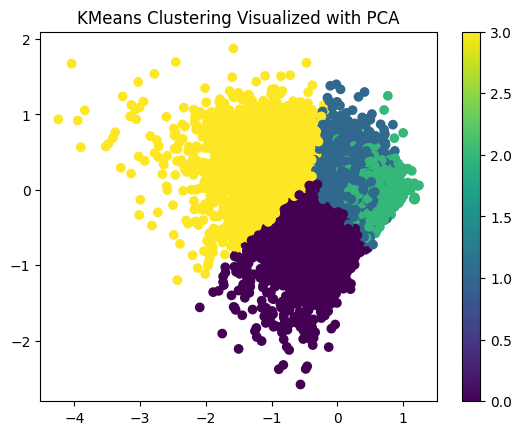

In [66]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=mbkmeans_clusters, cmap='viridis')
plt.colorbar()
plt.title('KMeans Clustering Visualized with PCA')
plt.show()

In [67]:
rgb_features_df = pd.DataFrame(rgb_features, columns=['Red', 'Green', 'Blue'])
rgb_features_df['Cluster'] = mbkmeans_clusters

# Generate summary statistics (mean, median, std) for each cluster based on RGB content
summary_rgb = rgb_features_df.groupby('Cluster').agg(['mean', 'median', 'std'])

In [68]:
summary_rgb

Red                              Green                        \
               mean      median        std        mean      median       std   
Cluster                                                                        
0        148.169079  147.624977  10.902319  165.250489  164.882569  7.522734   
1        145.829064  143.806505  13.558383  163.632721  162.224838  9.353465   
2        117.684497  119.040833  13.323043  144.211590  145.138750  9.195464   
3        151.743227  151.747894  14.117517  167.719830  167.699815  9.741477   

               Blue                         
               mean      median        std  
Cluster                                     
0        150.252102  149.726806  10.490724  
1        148.000931  146.056597  13.047302  
2        120.917500  122.217500  12.820193  
3        153.691866  153.698634  13.585322

In [69]:
num_clusters = len(np.unique(mbkmeans_clusters))  # Get the number of clusters
cluster_labels = to_categorical(mbkmeans_clusters, num_classes=num_clusters)

In [70]:
input_shape = features_scaled.shape[1]

In [71]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, cluster_labels, test_size=0.8, random_state=42)

In [72]:
# Build a simple fully connected model (since you're using extracted features, not raw images)
model = Sequential()

# Input layer (based on your extracted feature dimensions)
model.add(Dense(512, activation='relu', input_dim=features_scaled.shape[1]))
model.add(Dropout(0.5))

# Hidden layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output layer for predicting clusters
model.add(Dense(num_clusters, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\Shank\anaconda3\envs\dsenv3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [73]:
# Train the model using the training data
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.5341 - loss: 1.0415 - val_accuracy: 0.9328 - val_loss: 0.3061
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8416 - loss: 0.3908 - val_accuracy: 0.8521 - val_loss: 0.2988
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8608 - loss: 0.3289 - val_accuracy: 0.9002 - val_loss: 0.2323
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8903 - loss: 0.2763 - val_accuracy: 0.9546 - val_loss: 0.1487
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8830 - loss: 0.2826 - val_accuracy: 0.8938 - val_loss: 0.2504
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8962 - loss: 0.2523 - val_accuracy: 0.8938 - val_loss: 0.2434
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8840 - loss: 0.2831 - val_accuracy: 0.9194 - val_loss: 0.1870
Epoch 8/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.9067 - loss: 0.2281 - val_ac

In [50]:
# Step 1: Predict on the test set
y_pred = model.predict(X_test)

# Step 2: Convert predictions and true labels from one-hot encoding back to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

991/991 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [51]:
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes))

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5729
           1       0.95      0.97      0.96     13433
           2       0.99      0.94      0.96      8096
           3       0.99      0.92      0.95      4447

    accuracy                           0.96     31705
   macro avg       0.96      0.95      0.95     31705
weighted avg       0.96      0.96      0.96     31705



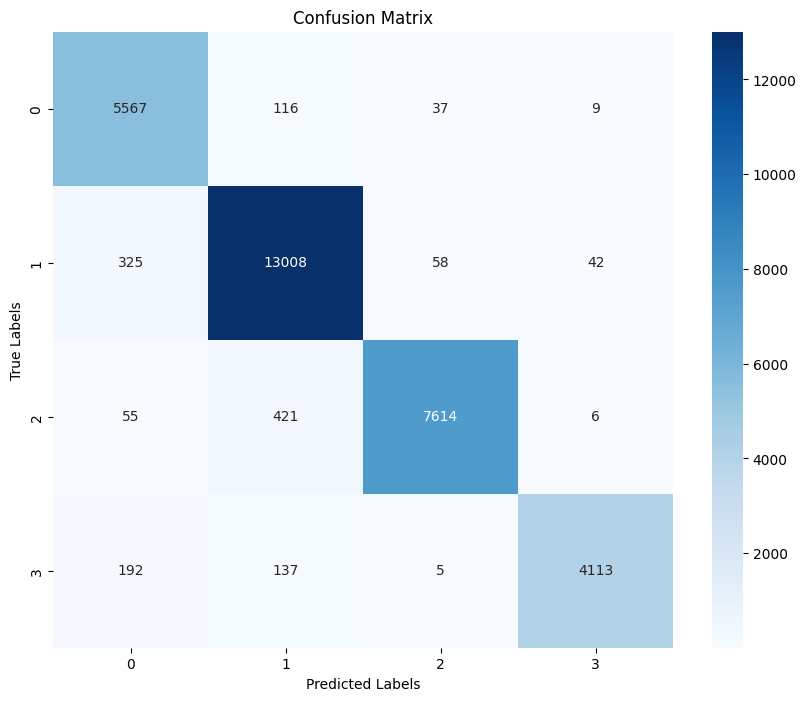

In [52]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Step 5: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [53]:
bp_song = pd.read_csv('data/bp_song.csv')

In [54]:
def compute_similarity(features_list, input_feature_vector, metric='euclidean'):
    if metric == 'euclidean':
        distances = [euclidean(input_feature_vector, feature) for feature in features_list]
    # You can add other metrics like cosine similarity
    return np.array(distances)

In [55]:
def recommend_items(input_track_id, features_list, track_ids_list, bp_song=bp_song, top_n=5):
    # Find the index of the input track's features
    input_index = track_ids_list.index(input_track_id)
    
    # Get the feature vector of the input track
    input_feature_vector = features_list[input_index]
    
    # Compute similarity between the input track and all other tracks
    similarities = compute_similarity(features_list, input_feature_vector, metric='euclidean')
    
    # Get the indices of the top_n most similar tracks (excluding the input track itself)
    most_similar_indices = similarities.argsort()[1:top_n + 1]  # Exclude the input track itself
    
    # Fetch the track_ids of the most similar items
    recommended_track_ids = [track_ids_list[idx] for idx in most_similar_indices]
    
    # Fetch the corresponding song titles and artists from the bp_song DataFrame
    recommended_songs = bp_song[bp_song['track_id'].isin(recommended_track_ids)]
    
    return recommended_songs[['track_id', 'song']]

In [56]:
input_track_id = 4993057  # Example track_id
top_n_recommendations = 5  # Get top 5 recommendations

# Fetch the input song's title and artist
input_song_info = bp_song[bp_song['track_id'] == input_track_id]['song'].values[0]

# Get the top N recommended songs
recommended_songs = recommend_items(input_track_id, features_list, track_ids_list, bp_song, top_n=top_n_recommendations)

# Output message with input song and recommendations
print(f"Top {top_n_recommendations} recommendations for {input_song_info}:\n")
print(recommended_songs)

Top 5 recommendations for Booyah feat. We Are Loud feat. Sonny Wilson by Showtek, Sonny Wilson, We Are Loud:

         track_id                                               song
1965374   4533966  Love Shot Me by Pete-R, JOEY aka Jozsef Keller...
2302865   5112899                               Believe by Mr. Green
4133618   8438116                                    Baila by Modium
5337758  10627897  Flex feat. General Levy by Fedde Le Grand, Fun...
8608771  15540798                                    Delver by Carbo


In [57]:
np.save('data/image_features_list.npy', features_list)
np.save('data/image_track_ids_list.npy', track_ids_list)